Code from https://github.com/moganesyan/tensorflow_model_deployment 
This notebook enables to test the tensorflow serving model created with 
* python Code/tfs_converter.py

Before running the notebook, you need to run a Docker environment so that you can make REST or GRpc request:
* /logs/build_image.sh

In [1]:
import os
import sys
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd
from PIL import Image

import requests

import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc
from tensorflow_serving.apis import predict_pb2
import tensorflow as tf


In [2]:
MRCNN_DIR = os.path.abspath('../')
sys.path.append(MRCNN_DIR)

In [4]:
from mrcnn import visualize

In [5]:
from tfs_transform import ImageTransform
from tfs_preprocess import PreprocessImage
from tfs_postprocess import PostprocessImage

### Configs

In [6]:
class_names = ['BG', 'glomerulus']

In [7]:
from glomerulus import GlomerulusInferenceConfig
config = GlomerulusInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

Using TensorFlow backend.


In [8]:
transformClass = ImageTransform(config)
preprocessClass = PreprocessImage(config)
postprocessClass = PostprocessImage(config)

### Prepare Image

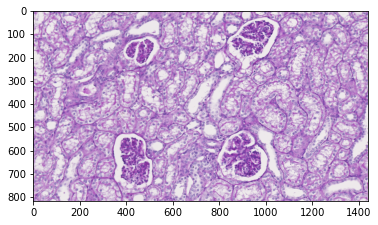

In [12]:
image = np.array(Image.open('../logs/TFS_img_test.tif'))
# If grayscale. Convert to RGB for consistency.
if image.ndim != 3:
    image = skimage.color.gray2rgb(image)
# If has an alpha channel, remove it for consistency
if image.shape[-1] == 4:
    image = image[..., :3]

plt.imshow(image)

In [13]:
molded_image, image_meta, anchors, window = preprocessClass.preprocess_input(image)

 # model run 
# molded_images, image_metas, windows = self.mold_inputs(images)
# anchors = self.get_anchors(image_shape)
# anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)


# 


### TF-SERVING REST Call

In [57]:
rest_payload = {
            "signature_name": "serving_default",
            "instances": [
                {
                    'input_anchors': anchors.tolist(),
                    'input_image': molded_image.tolist(),
                    'input_image_meta': image_meta.tolist()
                }]
            }
headers = {"content-type": "application/json"}
rest_json_response = requests.post('http://localhost:8501/v1/models/glomerulia_mrcnn:predict',
                              data = json.dumps(rest_payload),
                              headers = headers)


In [58]:
rest_json_response.status_code


200

In [44]:
rest_result = rest_json_response.json()
rest_mrcnn_detection = np.array(rest_result['predictions'][0]['mrcnn_detection/Reshape_1'])
rest_mrcnn_mask = np.array(rest_result['predictions'][0]['mrcnn_mask/Reshape_1'])
rest_rois, rest_class_ids, rest_scores, rest_masks = \
    postprocessClass.unmold_detections(rest_mrcnn_detection, rest_mrcnn_mask, image.shape, molded_image.shape, window)

####postprocess =
#             final_rois, final_class_ids, final_scores, final_masks =\
#                 self.unmold_detections(detections[i], mrcnn_mask[i],
#                                        image.shape, molded_images[i].shape,
#                                        windows[i])

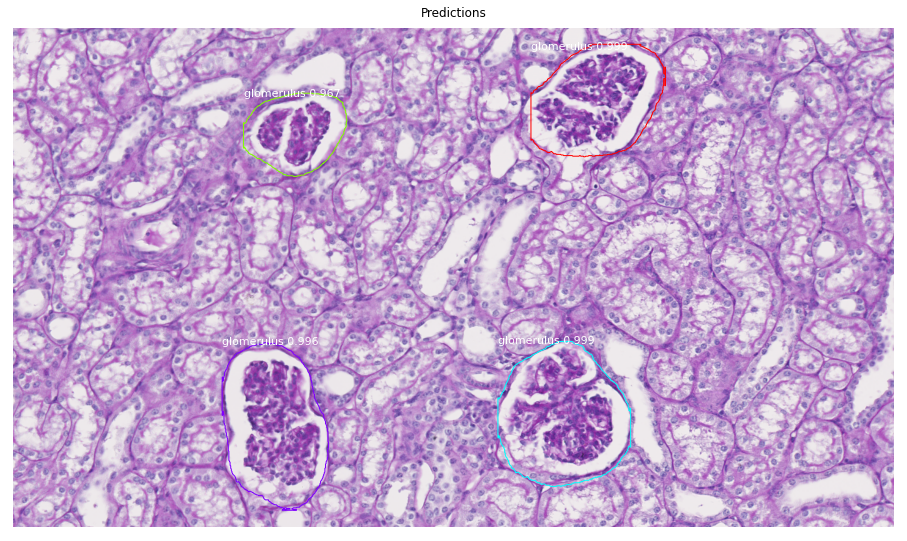

In [56]:
visualize.display_instances(
    image,
    rest_rois,
    rest_masks,
    rest_class_ids,
    class_names,
    rest_scores,
    show_bbox=False, 
    show_mask=False,
    title="Predictions"
)

In [46]:
# time
time_start = time.time()
repeat = 10
for i in range(repeat):
    rest_payload = {
                "signature_name": "serving_default",
                "instances": [
                    {
                        'input_anchors': anchors.tolist(),
                        'input_image': molded_image.tolist(),
                        'input_image_meta': image_meta.tolist()
                    }]
                }
    headers = {"content-type": "application/json"}
    rest_json_response = requests.post('http://localhost:8501/v1/models/glomerulia_mrcnn:predict',
                                  data = json.dumps(rest_payload),
                                  headers = headers)
        
    rest_result = rest_json_response.json()
    rest_mrcnn_detection = np.array(rest_result['predictions'][0]['mrcnn_detection/Reshape_1'])
    rest_mrcnn_mask = np.array(rest_result['predictions'][0]['mrcnn_mask/Reshape_1'])  

    rest_rois, rest_class_ids, rest_scores, rest_masks = \
    postprocessClass.unmold_detections(rest_mrcnn_detection, rest_mrcnn_mask, image.shape, molded_image.shape, window)
    

time_end = time.time()
time_elapsed_sec = time_end - time_start

print('Total elapsed time: {} seconds'.format(time_elapsed_sec))
print('Average latency per batch: {} seconds'.format(time_elapsed_sec / repeat))

Total elapsed time: 269.62520694732666 seconds
Average latency per batch: 26.962520694732667 seconds


cpu run : 
* Total elapsed time: 269.62520694732666 seconds
* Average latency per batch: 26.962520694732667 seconds

### TF-SERVING GRPC Call

In [47]:
channel = grpc.insecure_channel('localhost:8500', options=[('grpc.max_receive_message_length', 4096 * 4096 * 3)])

stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

request = predict_pb2.PredictRequest()
request.model_spec.name = 'glomerulia_mrcnn'
request.model_spec.signature_name = 'serving_default'
np.expand_dims(image, axis=0)

request.inputs['input_image'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(molded_image, axis=0), shape = np.expand_dims(molded_image, axis=0).shape, dtype = "float32"))
request.inputs['input_image_meta'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(image_meta, axis=0), shape = np.expand_dims(image_meta, axis=0).shape, dtype = "float32"))
request.inputs['input_anchors'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(anchors, axis=0), shape = np.expand_dims(anchors, axis=0).shape, dtype = "float32"))

grpc_result = stub.Predict(request)

In [48]:
grpc_mrcnn_detection = np.array(grpc_result.outputs["mrcnn_detection/Reshape_1"].float_val)
grpc_mrcnn_mask = np.array(grpc_result.outputs["mrcnn_mask/Reshape_1"].float_val)
grpc_rois, grpc_class_ids, grpc_scores, grpc_masks = \
    postprocessClass.unmold_detections(grpc_mrcnn_detection, grpc_mrcnn_mask, image.shape, molded_image.shape, window)

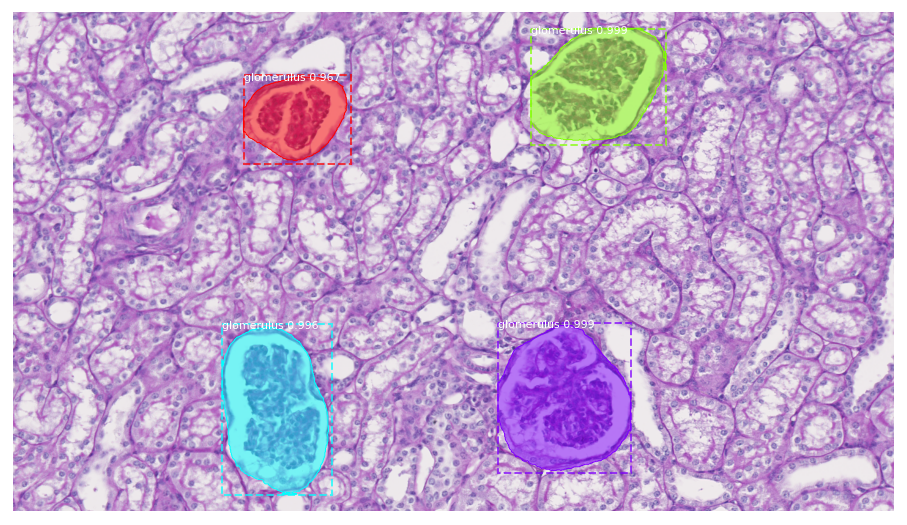

In [49]:
visualize.display_instances(
    image,
    grpc_rois,
    grpc_masks,
    grpc_class_ids,
    class_names,
    grpc_scores
)

In [51]:
# time
time_start = time.time()
repeat = 10
for i in range(repeat):
    request = predict_pb2.PredictRequest()
    request.model_spec.name = 'glomerulia_mrcnn'
    request.model_spec.signature_name = 'serving_default'
    np.expand_dims(image, axis=0)

    request.inputs['input_image'].CopyFrom(
        tf.make_tensor_proto(np.expand_dims(molded_image, axis=0), shape = np.expand_dims(molded_image, axis=0).shape, dtype = "float32"))
    request.inputs['input_image_meta'].CopyFrom(
        tf.make_tensor_proto(np.expand_dims(image_meta, axis=0), shape = np.expand_dims(image_meta, axis=0).shape, dtype = "float32"))
    request.inputs['input_anchors'].CopyFrom(
        tf.make_tensor_proto(np.expand_dims(anchors, axis=0), shape = np.expand_dims(anchors, axis=0).shape, dtype = "float32"))

    grpc_result = stub.Predict(request)
    
    grpc_mrcnn_detection = np.array(grpc_result.outputs["mrcnn_detection/Reshape_1"].float_val)
    grpc_mrcnn_mask = np.array(grpc_result.outputs["mrcnn_mask/Reshape_1"].float_val)

    grpc_rois, grpc_class_ids, grpc_scores, grpc_masks = \
    postprocessClass.unmold_detections(grpc_mrcnn_detection, grpc_mrcnn_mask, image.shape, molded_image.shape, window)
    
time_end = time.time()
time_elapsed_sec = time_end - time_start

print('Total elapsed time: {} seconds'.format(time_elapsed_sec))
print('Average latency per batch: {} seconds'.format(time_elapsed_sec / repeat))

Total elapsed time: 154.21868515014648 seconds
Average latency per batch: 15.421868515014648 seconds


cpu run : 
* Total elapsed time: 154.21868515014648 seconds
* Average latency per batch: 15.421868515014648 seconds